# Import libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as nn
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

## Check for CUDA

In [2]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


## Download and transform dataset

In [3]:
batch_size=20
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),
                                                   (0.5,0.5,0.5))])

train_data=datasets.CIFAR10('data',train=True,download=True, transform=transform)
test_data=datasets.CIFAR10('data',train=False,download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
val_size=0.2
num_train=len(train_data)
indices=list(range(num_train))
np.random.shuffle(indices)
split= int(np.floor(val_size*num_train))
train_idx,val_idx= indices[split:], indices[:split]
train_sampler= SubsetRandomSampler(train_idx)
val_sampler= SubsetRandomSampler(val_idx)
train_loader= torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                          sampler=train_sampler)
val_loader= torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                        sampler=val_sampler)
test_loader= torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [0]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

## Visualizing a batch of images

In [0]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

torch.Size([3, 32, 32])


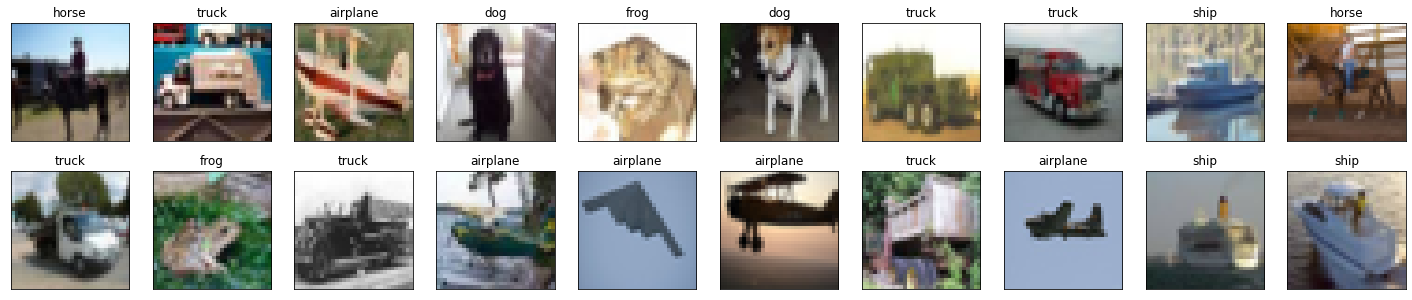

In [7]:
dataiter=iter(train_loader)
images, labels=dataiter.next()
print(images[0].shape)
images=images.numpy()
fig=plt.figure(figsize=(25,5))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Defining the model


In [8]:
import torch.nn as nn
import torch.nn.functional as f
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1= nn.Conv2d(3,16,3,padding= 1)
        self.conv2= nn.Conv2d(16,32,3,padding= 1)
        self.conv3= nn.Conv2d(32,32,3,padding= 1)
        self.pool= nn.MaxPool2d(2,2)
        self.dropout= nn.Dropout(0.25)
        self.fc1= nn.Linear(32*4*4, 256)
        self.fc2= nn.Linear(256, 10)
    def forward(self,x):
        x= self.pool(f.relu(self.conv1(x)))
        x= self.pool(f.relu(self.conv2(x)))
        x= self.pool(f.relu(self.conv3(x)))
        x= self.dropout(x)
        x= x.view(-1,32*4*4)
        x= f.relu(self.fc1(x))
        x= self.fc2(x)
        return x

model=Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [0]:
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr= 0.01)

## Training

In [0]:
if train_on_gpu:
    model.cuda()

In [14]:
epochs=15
valid_loss_min=np.Inf
for e in range(1,epochs+1):
    train_loss=0
    valid_loss=0
    model.train()
    #Training 
    for images, targets in train_loader:
        optimizer.zero_grad()
        if train_on_gpu:
            images,targets= images.cuda(), targets.cuda()
        output= model(images)
        loss= criterion(output,targets)
        loss.backward()
        optimizer.step()
        train_loss+= loss.item()*images.size(0)
    #Validating
    model.eval()
    for images,targets in val_loader:
        if train_on_gpu:
            images, targets = images.cuda(), targets.cuda()
        
        output= model(images)
        loss= criterion(output, targets)
        
        valid_loss+= loss.item()*images.size(0)
        
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
        
    
        

Epoch: 1 	Training Loss: 1.204088 	Validation Loss: 0.279959
Validation loss decreased (inf --> 0.279959).  Saving model ...
Epoch: 2 	Training Loss: 1.121964 	Validation Loss: 0.260162
Validation loss decreased (0.279959 --> 0.260162).  Saving model ...
Epoch: 3 	Training Loss: 1.044932 	Validation Loss: 0.251699
Validation loss decreased (0.260162 --> 0.251699).  Saving model ...
Epoch: 4 	Training Loss: 0.983071 	Validation Loss: 0.228476
Validation loss decreased (0.251699 --> 0.228476).  Saving model ...
Epoch: 5 	Training Loss: 0.921839 	Validation Loss: 0.227337
Validation loss decreased (0.228476 --> 0.227337).  Saving model ...
Epoch: 6 	Training Loss: 0.873528 	Validation Loss: 0.213335
Validation loss decreased (0.227337 --> 0.213335).  Saving model ...
Epoch: 7 	Training Loss: 0.830600 	Validation Loss: 0.203777
Validation loss decreased (0.213335 --> 0.203777).  Saving model ...
Epoch: 8 	Training Loss: 0.794051 	Validation Loss: 0.188591
Validation loss decreased (0.20377

In [15]:
model.load_state_dict(torch.load('model_cifar.pt'))


<All keys matched successfully>

## Testing

In [16]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.816650

Test Accuracy of airplane: 74% (741/1000)
Test Accuracy of automobile: 85% (852/1000)
Test Accuracy of  bird: 58% (580/1000)
Test Accuracy of   cat: 45% (456/1000)
Test Accuracy of  deer: 71% (710/1000)
Test Accuracy of   dog: 61% (615/1000)
Test Accuracy of  frog: 79% (793/1000)
Test Accuracy of horse: 79% (793/1000)
Test Accuracy of  ship: 84% (846/1000)
Test Accuracy of truck: 78% (785/1000)

Test Accuracy (Overall): 71% (7171/10000)


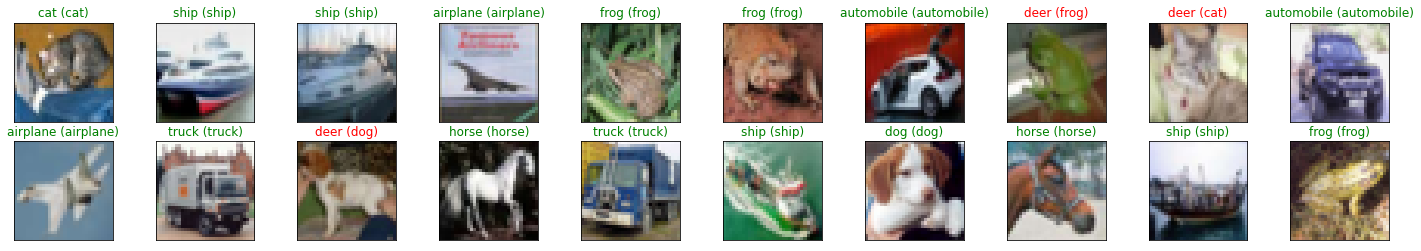

In [17]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)

images=images.cpu()
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))